In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score 
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

In [2]:
def freq_enc(df, cols):
    for col in cols:
        df[col]= df[col].map(round(df[col].value_counts()/len(df),4))
    return df

def outlier_zscore(df):
    df= df.select_dtypes(include= 'number')
    for col in df.columns:
        upper= df[col].mean() + 2 *  df[col].std()
        lower= df[col].mean() - 2 *  df[col].std()
        df[col][df[col] > upper]= df[col].mean()
        df[col][df[col] < lower]= df[col].mean()
    return df

def to_df(data, cols):
    df= pd.DataFrame(data, columns= cols)
    return df

In [3]:
df= pd.read_csv('CarPrice_A.csv')
df.shape

(205, 26)

In [4]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
car_make= df['CarName'].apply(lambda x: x.split(' ')[0])
df.insert(2, 'car_make', car_make)
df.drop(columns= ['CarName', 'car_ID'], inplace= True)

In [6]:
df['car_make'] = df['car_make'].replace(["maxda", "porcshce", "toyouta", "vokswagen", "vw", "Nissan"], 
                    ["mazda", "porsche", "toyota", "volkswagen", "volkswagen", "nissan"])
df= freq_enc(df, ['car_make'])

df_cat= df.select_dtypes(include= 'object')
df_num= df.select_dtypes(include= 'number')
df_cat.shape

(205, 9)

In [7]:
df_cat.head()

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [8]:
for col in df_cat.columns:
    print(f'{col} --> {df_cat[col].nunique()}')

fueltype --> 2
aspiration --> 2
doornumber --> 2
carbody --> 5
drivewheel --> 3
enginelocation --> 2
enginetype --> 7
cylindernumber --> 7
fuelsystem --> 8


With the info above, we can do a get dummies on df_cat

In [9]:
df_cat= pd.get_dummies(df_cat[df_cat.columns[1:]], drop_first= True)

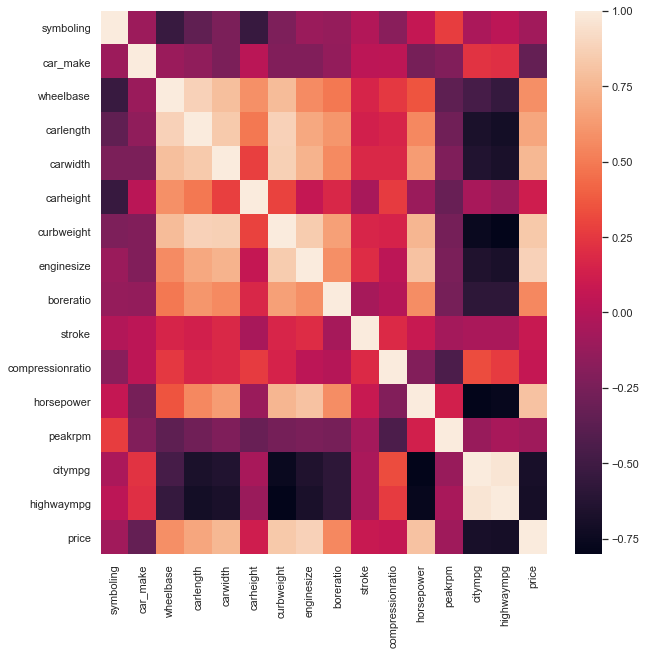

In [10]:
sns.heatmap(df_num.corr())

In [11]:
label= df_num['price']
df_num= df_num.drop(columns= ['price'])

df_num= outlier_zscore(df_num)

scaler= StandardScaler()
df_num= to_df(scaler.fit_transform(df_num), df_num.columns)

data= pd.concat([df_num, df_cat], 1)
data.head()

,symboling,car_make,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,1.780260,-2.001885,-2.044035,-0.433663,-0.953499,-0.035688,0.102369,0.269024,0.549243,-2.322292,0.019531,0.359581,-0.314562,-0.654618,-0.567373,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,1.780260,-2.001885,-2.044035,-0.433663,-0.953499,-0.035688,0.102369,0.269024,0.549243,-2.322292,0.019531,0.359581,-0.314562,-0.654618,-0.567373,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0.104231,-2.001885,-0.773293,-0.195863,-0.047531,-0.564809,0.737937,0.996574,-0.027471,0.855924,0.019531,1.727567,-0.314562,-0.990253,-0.741098,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.942245,-1.058480,0.368222,0.339185,0.405454,0.357619,-0.385285,-0.425456,-0.555290,0.574310,1.341254,0.073259,0.857730,-0.151166,-0.046198,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.942245,-1.058480,0.282070,0.339185,0.534878,0.357619,0.740248,0.467447,-0.555290,0.574310,-1.302192,0.486836,0.857730,-1.158071,-1.435999,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [12]:
X_train, X_test, y_train, y_test= train_test_split(data, label, test_size= 0.25, random_state= 1)

In [35]:
# # Just parameters i used for some of my previous models
# rf_params={'n_estimators': 800,
#            'criterion': 'mse',
#            'max_depth': 20,
#            'min_samples_split': 70,
#            'min_samples_leaf': 15,
#            'max_features': 0.60,
#            'bootstrap': True,
#            'max_samples': 0.5,
#            'n_jobs': -1}

# lgb_params= {'learning_rate':0.02, #<
#              'metric': 'RMSE',
#              'boosting_type':'dart',
#              'num_leaves': 300, #>
#              'max_depth': 20, #>
#              'n_estimators': 150,
#              'subsample_for_bin':200000, #>
#              'objective': 'regression',
#              'min_split_gain': 0.002,
#              'min_child_samples': 15,
#              'subsample': 0.5,
#              'subsample_freq': 1,
#              'colsample_bytree': 0.8,
#              'reg_alpha': 15,
#              'reg_lambda': 40,
#              'n_jobs': -1}

# #model= RandomForestRegressor(**rf_params)
# #model= LGBMRegressor(n_estimators=5000, boosting_type='dart', max_depth= 16,)

# model=CatBoostRegressor(eval_metric= 'RMSE', random_state=1, learning_rate=0.05, depth= 8, l2_leaf_reg=12, 
#                         random_strength=0, n_estimators=1000, bagging_temperature=0.02, od_type='Iter', metric_period=75, 
#                         od_wait=100)
# # Get a list of categorical features for the catboost algorithm
# for i in cat_list:
#     if i not in train.columns:
#         cat_list.remove(i)
# cat_features= []
# for i in cat_list:
#     cat_features.append(train.columns.get_loc(i))
# # Fit model
# model.fit(train_1, label_1, cat_features= cat_features)

In [65]:
model=CatBoostRegressor(eval_metric= 'RMSE', random_state=1, learning_rate=0.05, depth= 8, l2_leaf_reg=12, 
                        random_strength=0, n_estimators=1000, bagging_temperature=0.02, od_type='Iter', metric_period=75, 
                        od_wait=100)
model.fit(X_train, y_train)

0:	learn: 7724.6896302	total: 10.2ms	remaining: 10.2s
75:	learn: 2713.4898734	total: 665ms	remaining: 8.09s
150:	learn: 1701.6263747	total: 1.37s	remaining: 7.73s
225:	learn: 1331.0497544	total: 1.95s	remaining: 6.68s
300:	learn: 1097.3741424	total: 2.69s	remaining: 6.24s
375:	learn: 913.5522749	total: 3.33s	remaining: 5.52s
450:	learn: 792.5392381	total: 3.95s	remaining: 4.8s
525:	learn: 689.6128334	total: 4.63s	remaining: 4.17s
600:	learn: 608.6959412	total: 5.38s	remaining: 3.57s
675:	learn: 564.6326961	total: 6.07s	remaining: 2.91s
750:	learn: 527.3227933	total: 6.7s	remaining: 2.22s
825:	learn: 499.3216869	total: 7.32s	remaining: 1.54s
900:	learn: 470.6232732	total: 7.91s	remaining: 869ms
975:	learn: 443.9318508	total: 8.51s	remaining: 209ms
999:	learn: 434.7837148	total: 8.78s	remaining: 0us


In [66]:
# for train data
pred_train= model.predict(X_train)
mae= mean_absolute_error(pred_train, y_train)
mse= mean_squared_error(pred_train, y_train)
r2= r2_score(pred_train, y_train)
print(f'Train MAE: {mae} \n Train MSE: {mse**0.5} \n Test r2_score: {r2}')

# for test data
pred_test= model.predict(X_test)
mae= mean_absolute_error(pred_test, y_test)
mse= mean_squared_error(pred_test, y_test)
r2_= r2_score(y_test, pred_test)
print(f'\nTest MAE: {mae} \n Test MSE: {mse**0.5} \n Test r2_score: {r2_}')

Train MAE: 336.6072089345751 
 Train MSE: 434.7837169041692 
 Test r2_score: 0.9969045194470104

Test MAE: 1574.5025058538702 
 Test MSE: 2449.942310261694 
 Test r2_score: 0.910604683583766


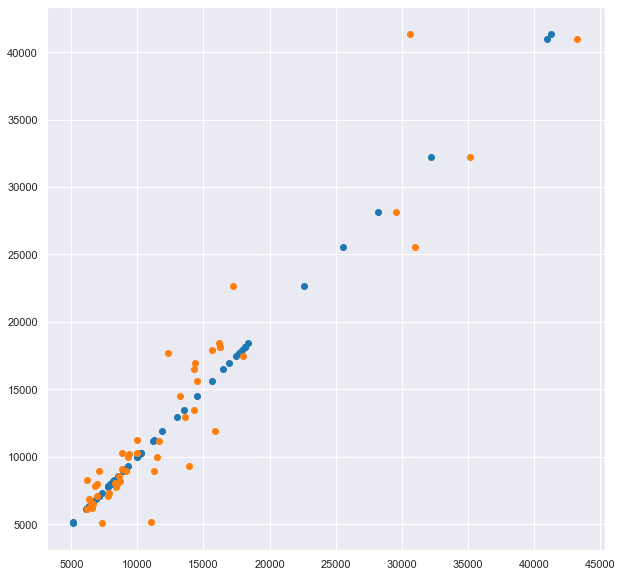

In [54]:
plt.scatter(y_test, y_test)
plt.scatter(pred_test, y_test)